# Calculation of p-values

This notebook is for generating figures 8, 13, 14 of arXiv:1805.02664

### Import and initialize some functions

In [8]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson, norm, kstest
import numdifftools
from numpy.linalg import inv
import matplotlib.gridspec as gridspec
filenames_nosig = ["../data/finalscan_nosignal/0_005_" + str(i) + "_bincounts.dat" for i in range(3,12)]
filenames_sig = ["../data/finalscan_signal/sig_bin" + str(i) + "_bincounts.dat" for i in range(3,12)]
datasets_nosig = np.array([np.loadtxt(filename) for filename in filenames_nosig])
datasets_sig = np.array([np.loadtxt(filename) for filename in filenames_sig])

def get_p_value(ydata,binvals,mask=[],verbose=0,plotfile=None,yerr=None,return_teststat = False,plotsys=True,myax=None):

    ydata = np.array(ydata)
    #Assume poisson is gaussian with N+1 variance
    if not yerr:
        yerr = np.sqrt(ydata+1)
    else:
        yerr=np.array(yerr)
        
    def fit_func(x,p1,p2,p3):
        #see the ATLAS diboson resonance search: https://arxiv.org/pdf/1708.04445.pdf.
        xi = 0.
        y = x/13000.
        return p1*(1.-y)**(p2-xi*p3)*y**-p3

    xdata = np.array([0.5*(binvals[i]+binvals[i+1]) for i in range(0,len(binvals)-1)])
    xwidths = np.array([-binvals[i]+binvals[i+1] for i in range(0,len(binvals)-1)])

    #Assuming inputs are bin counts, this is needed to get densities. Important for variable-width bins
    ydata = np.array(ydata) * 100 / xwidths
    yerr = np.array(yerr)*100/ np.array(xwidths)

    #Least square fit, masking out the signal region
    popt, pcov = curve_fit(fit_func, np.delete(xdata,mask), np.delete(ydata,mask),sigma=np.delete(yerr,mask),maxfev=10000)
    if verbose:
        print('fit params: ', popt)

    ydata_fit = np.array([fit_func(x,popt[0],popt[1],popt[2]) for x in xdata])

    #Check that the function is a good fit to the sideband
    residuals = np.delete((ydata - ydata_fit)/yerr,mask)
    
    if verbose > 0:
        print("Goodness: ",kstest(residuals, norm(loc=0,scale=1).cdf))
        print(residuals)
        print(((ydata - ydata_fit)/yerr)[mask])
        print('\n')

    #The following code is used to get the bin errors by propagating the errors on the fit params
    def fit_func_array(parr):
        #see the ATLAS diboson resonance search: https://arxiv.org/pdf/1708.04445.pdf.
        p1, p2, p3 = parr
        xi = 0.
        return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])
    
    jac=numdifftools.core.Jacobian(fit_func_array)
    x_cov=np.dot(np.dot(jac(popt),pcov),jac(popt).T)
    #For plot, take systematic error band as the diagonal of the covariance matrix
    y_unc=np.sqrt([row[i] for i, row in enumerate(x_cov)])

    if (plotfile != None) & (plotfile != 'ax'):
        if plotsys:
            plt.fill_between(xdata,ydata_fit+y_unc,ydata_fit-y_unc,facecolor='gray',edgecolor=None,alpha=0.4)
        yerr2 = np.array(yerr)
        yerr2[yerr>=ydata] = yerr2[yerr>=ydata]*0.8
        plt.errorbar(xdata, ydata,[yerr2,yerr],None, 'bo', label='data',markersize=4)
        plt.plot(xdata, ydata_fit, 'r--', label='data')
        plt.yscale('log', nonposy='clip')
    if plotfile == 'ax':
        if plotsys:
            myax.fill_between(xdata,ydata_fit+y_unc,ydata_fit-y_unc,facecolor='gray',edgecolor=None,alpha=0.4)
        yerr2 = np.array(yerr)
        yerr2[yerr>=ydata] = yerr2[yerr>=ydata]*0.8
        myax.errorbar(xdata, ydata,[yerr2,yerr],None, 'bo', label='data',markersize=4)
        myax.plot(xdata, ydata_fit, 'r--', label='data')
        myax.set_yscale('log', nonposy='clip')
    if plotfile == 'show':
        plt.show()
    elif plotfile:
        plt.savefig(plotfile)
        
    #Now, let's compute some statistics.
    #  Will use asymptotic formulae for p0 from Cowan et al arXiv:1007.1727
    #  and systematics procedure from https://cds.cern.ch/record/2242860/files/NOTE2017_001.pdf
    
    #First get systematics in the signal region
    
    #This function returns array of signal predictions in the signal region
    def signal_fit_func_array(parr):
        #see the ATLAS diboson resonance search: https://arxiv.org/pdf/1708.04445.pdf.
        p1, p2, p3 = parr
        xi = 0.
        return np.array([np.sum([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3*xwidths[mask[i]]/100 for i, x in enumerate(xdata[mask])])])
    #Get covariance matrix of prediction uncertainties in the signal region
    jac=numdifftools.core.Jacobian(signal_fit_func_array)
    x_signal_cov=np.dot(np.dot(jac(popt),pcov),jac(popt).T)
    #Inverse signal region covariance matrix:
    inv_x_signal_cov = inv(x_signal_cov)
    
    #Get observed and predicted event counts in the signal region
    obs = np.array([np.sum(np.array(ydata)[mask]*np.array(xwidths)[mask]/100)])
    expected = np.array([np.sum([fit_func(xdata[targetbin],popt[0],popt[1],popt[2])*xwidths[targetbin]/100 for targetbin in mask])])
    
    #Negative numerator of log likelihood ratio, for signal rate mu = 0
    def min_log_numerator(expected_nuis_arr):
        #expected_nuis_arr is the array of systematic background uncertainty nuisance parameters
        #These are event rate densities
        expected_nuis_arr = np.array(expected_nuis_arr)
        to_return = 0
        #Poisson terms
        for i, expected_nuis in enumerate(expected_nuis_arr):
            #Poisson lambda. Have to rescale nuisance constribution by bin width
            my_lambda = expected[i]+expected_nuis_arr[i]
            #Prevent negative predicted rates
            if my_lambda < 10**-10:
                my_lambda = 10**-10
            #Poisson term. Ignore the factorial piece which will cancel in likelihood ratio
            to_return = to_return + (obs[i]*np.log(my_lambda) - my_lambda)
            
        #Gaussian nuisance term
        nuisance_term = -0.5*np.dot(np.dot(expected_nuis_arr,inv_x_signal_cov),expected_nuis_arr)
        to_return = to_return + nuisance_term
        return -to_return

    def jac_min_log_numerator(expected_nuis_arr):
        #expected_nuis_arr is the array of systematic background uncertainty nuisance parameters
        #These are event rate densities
        expected_nuis_arr = np.array(expected_nuis_arr)
        to_return = np.array([0.])
        #Poisson terms
        #Poisson lambda. Have to rescale nuisance constribution by bin width
        my_lambda = expected+expected_nuis_arr
        dmy_lambda = np.array([1.])
        #Prevent negative predicted rates
        my_lambda[my_lambda < 10**-10] = np.ones(len(my_lambda[my_lambda < 10**-10])) * 10**-10
        dmy_lambda[my_lambda < 10**-10] = 0
        #Poisson term. Ignore the factorial piece which will cancel in likelihood ratio
        to_return = to_return + (obs*dmy_lambda/my_lambda - dmy_lambda)
        #Gaussian nuisance term
        nuisance_term = -np.dot(inv_x_signal_cov,expected_nuis_arr)
        to_return = to_return + nuisance_term
        return -to_return
    
    #Initialization of nuisance params
    expected_nuis_array_init = [0.02]
    
    #shift log likelihood to heklp minimization algo
    def rescaled_min_log_numerator(expected_nuis_arr):
        return min_log_numerator(expected_nuis_arr) - min_log_numerator(expected_nuis_array_init)
    
    #Perform minimization over nuisance parameters. Set bounds for bg nuisance at around 8 sigma.
    bnds=[[-8*y_unc[mask[0]],8*y_unc[mask[0]]]]
    minimize_log_numerator = minimize(rescaled_min_log_numerator,
                                      expected_nuis_array_init,
                                      jac=jac_min_log_numerator,
                                      bounds=bnds)
    
    if verbose:
        print("numerator: ",  minimize_log_numerator.items(),'\n')
        
    #Now get likelihood ratio denominator
    def min_log_denom(nuis_arr):
        #nuis_arr contains the bg systematics and also the signal rate
        expected_nuis_arr = np.array(nuis_arr)[:1]
        #print(expected_nuis_arr)
        mu = nuis_arr[1]
        #Signal prediction
        pred = [mu]
        to_return = 0
        #Poisson terms
        for i, expected_nuis in enumerate(expected_nuis_arr):
            #Poisson lambda
            my_lambda = expected[i]+expected_nuis_arr[i] + pred[i]
            #Prevent prediction from going negative
            if my_lambda < 10**-10:
                my_lambda = 10**-10
            #Poisson term. Ignore the factorial piece which will cancel in likelihood ratio
            to_return = to_return + (obs[i]*np.log(my_lambda) - my_lambda)

        #Gaussian nuisance term
        nuisance_term = -0.5*np.dot(np.dot(expected_nuis_arr,inv_x_signal_cov),expected_nuis_arr)
        to_return = to_return + nuisance_term
        return -to_return

    def jac_min_log_denom(nuis_arr):
        #expected_nuis_arr is the array of systematic background uncertainty nuisance parameters
        #These are event rate densities
        expected_nuis_arr = np.array(nuis_arr)[:1]
        mu = nuis_arr[1]
        pred = [mu]
        to_return_first = np.array([0.])
        #Poisson terms
        #Poisson lambda. Have to rescale nuisance constribution by bin width
        my_lambda = expected+expected_nuis_arr+pred
        dmy_lambda = np.array([1.])
        #Prevent prediction from going negative
        my_lambda[my_lambda < 10**-10] = np.ones(len(my_lambda[my_lambda < 10**-10])) * 10**-10
        dmy_lambda[my_lambda < 10**-10] = 0
        #Poisson term. Ignore the factorial piece which will cancel in likelihood ratio
        to_return_first = to_return_first + (obs*dmy_lambda/my_lambda - dmy_lambda)
        #Gaussian nuisance term
        nuisance_term = -np.dot(inv_x_signal_cov,expected_nuis_arr)
        to_return_first = to_return_first + nuisance_term
        
        to_return_last = np.array([0.])
        
        dpred = np.array([[1.]])
        
        my_lambda = expected+expected_nuis_arr+pred
        dmy_lambda = dpred
        to_return_last = np.dot((obs/my_lambda),dmy_lambda.T) - np.sum(dmy_lambda,axis=1)
        
        return -np.append(to_return_first, to_return_last)
    
    #initizalization for minimization
    nuis_array_init = [0.01,1.]
    
    #Shift log likelihood for helping minimization algo.
    def rescaled_min_log_denom(nuis_arr):
        return min_log_denom(nuis_arr) - min_log_denom(nuis_array_init)
    
    bnds = ((None,None),(None,None))
    minimize_log_denominator = minimize(rescaled_min_log_denom,nuis_array_init,
                                        jac=jac_min_log_denom,
                                        bounds=bnds)
    
    if verbose:
        print("Denominator: ",  minimize_log_denominator.items(),'\n')
        
    if minimize_log_denominator.x[-1] < 0:
        Zval = 0
        neglognum = 0
        neglogden = 0
    else:
        neglognum = min_log_numerator(minimize_log_numerator.x)
        neglogden = min_log_denom(minimize_log_denominator.x)
        Zval = np.sqrt(2*(neglognum - neglogden))
      
    
    p0 = 1-norm.cdf(Zval)
    
    if verbose:
        print("z = ", Zval)
        print("p0 = ", p0)

    #plt.title(str(p0))
#     if plotfile == 'show':
#         plt.show()
#     elif plotfile:
#         plt.savefig(plotfile)

    if return_teststat:
        return p0, 2*(neglognum - neglogden)
    else:
        return p0



In [2]:
def add_mjjplot(ydata,binvals,mask=[],verbose=0,plotfile=None,yerr=None,plotsys=True,myax=None,plotfit=True):

    ydata = np.array(ydata)
    #Assume poisson is gaussian with N+1 variance
    if not yerr:
        yerr = np.sqrt(ydata+1)
    else:
        yerr=np.array(yerr)
        
    def fit_func(x,p1,p2,p3):
        #see the ATLAS diboson resonance search: https://arxiv.org/pdf/1708.04445.pdf.
        xi = 0.
        y = x/13000.
        return p1*(1.-y)**(p2-xi*p3)*y**-p3

    xdata = np.array([0.5*(binvals[i]+binvals[i+1]) for i in range(0,len(binvals)-1)])
    xwidths = np.array([-binvals[i]+binvals[i+1] for i in range(0,len(binvals)-1)])

    #Assuming inputs are bin counts, this is needed to get densities. Important for variable-width bins
    ydata = np.array(ydata) * 100 / xwidths
    yerr = np.array(yerr)*100/ np.array(xwidths)

    #Least square fit, masking out the signal region
    popt, pcov = curve_fit(fit_func, np.delete(xdata,mask),
                           np.delete(ydata,mask),
                           sigma=np.delete(yerr,mask),maxfev=10000)
    if verbose:
        print('fit params: ', popt)

    ydata_fit = np.array([fit_func(x,popt[0],popt[1],popt[2]) for x in xdata])

    #Check that the function is a good fit to the sideband
    residuals = np.delete((ydata - ydata_fit)/yerr,mask)
    
    if verbose > 0:
        print("Goodness: ",kstest(residuals, norm(loc=0,scale=1).cdf))
        print(residuals)
        print(((ydata - ydata_fit)/yerr)[mask])
        print('\n')

    #The following code is used to get the bin errors by propagating the errors on the fit params
    def fit_func_array(parr):
        #see the ATLAS diboson resonance search: https://arxiv.org/pdf/1708.04445.pdf.
        p1, p2, p3 = parr
        xi = 0.
        return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])
    
    jac=numdifftools.core.Jacobian(fit_func_array)
    x_cov=np.dot(np.dot(jac(popt),pcov),jac(popt).T)
    #For plot, take systematic error band as the diagonal of the covariance matrix
    y_unc=np.sqrt([row[i] for i, row in enumerate(x_cov)])

    if (plotfile != None) & (plotfile != 'ax'):
        if plotfit:
            if plotsys:
                plt.fill_between(xdata,ydata_fit+y_unc,ydata_fit-y_unc,color='gray',alpha=0.4)
            plt.plot(xdata, ydata_fit, 'r--', label='data')
        plt.errorbar(xdata, ydata,yerr,None, 'bo', label='data',markersize=4)
        plt.yscale('log', nonposy='clip')
    if plotfile == 'ax':
        if plotfit:
            if plotsys:
                myax.fill_between(xdata,ydata_fit+y_unc,ydata_fit-y_unc,color='gray',alpha=0.4)
            myax.plot(xdata, ydata_fit, 'r--', label='data')
        myax.errorbar(xdata, ydata,yerr,None, 'bo', label='data',markersize=4)
        myax.set_yscale('log', nonposy='clip')
    if plotfile == 'show':
        plt.show()
    elif plotfile:
        plt.savefig(plotfile)


### Define the binning

In [3]:
binvals = [#1900.,
            2001.,2107.,2219.,2337.,2461.,2592.,2730.,2875.,3028.,3189.,3358.,3536.,3724.,3922.,4131.,4350.]
bincenters = [0.5*(binvals[i] + binvals[i+1]) for i in range(len(binvals)-1)]

### Calculate and plot p-values for mass scan

Figure 8, right

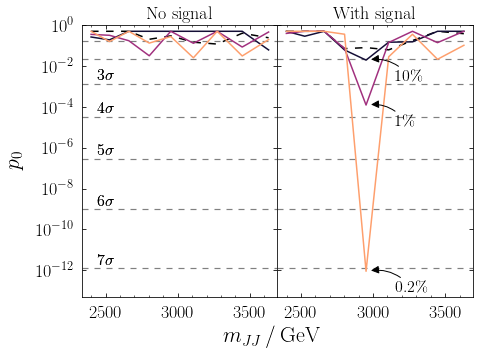

In [4]:
fontsize=22
smfontsize=16

binvals = [#1900.,
            2001.,2107.,2219.,2337.,2461.,2592.,2730.,2875.,3028.,3189.,3358.,3536.,3724.,3922.,4131.,4350.]
bincenters = [0.5*(binvals[i] + binvals[i+1]) for i in range(len(binvals)-1)]
bincenters = bincenters[3:12]
masks = [[bin_i-1,bin_i, bin_i+1] for bin_i in range(3,12)]
plt.close('all')
f, axarr = plt.subplots(1,2, sharex=True, sharey=True,figsize=(5*1.4,5))
# plt.figure(figsize=(5,5))

linestyles = [{'dashes':[5,5]},{'linestyle':'-'},{'linestyle':'-'},{'linestyle':'-'},{'linestyle':'-'}]
choices = [0,1,4,6]
colors = ['black']
colors.extend([plt.cm.magma(i) for i in np.linspace(0.1,0.8,len(choices)-1)])
# colors = ['black']
# colors.extend([plt.cm.viridis(i) for i in np.linspace(0.1,0.95,len(choices)-1)])
effs = [r"100\%",r"10\%",r"1\%",r"0.2\%"]

dashes = [5,5]
color='0.5'
linewidth=1.2

for ax in axarr:
    for sigma in range(1,8):
        ax.axhline(1-norm.cdf(sigma),dashes=dashes,color=color,linewidth=linewidth)
        if sigma > 2:
            sigmastring = r'$' + str(sigma) + '\sigma$'
            axarr[0].text(2500,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=smfontsize)




for eff_i, effchoice in enumerate(choices):

    pvalues_nosig = [get_p_value(ydata[1:],binvals,mask=masks[i],verbose=0,plotfile=None)
                     for i, ydata in enumerate(datasets_nosig[:,effchoice])]

    pvalues_sig = [get_p_value(ydata[1:],binvals,mask=masks[i],verbose=0,plotfile=None)
                   for i, ydata in enumerate(datasets_sig[:,effchoice])]

#     plt.subplot(1,2,1)
    axarr[0].plot(bincenters,pvalues_nosig,
                  color=colors[eff_i],
                  **linestyles[eff_i])
    #plt.subplot(1,2,2)
    axarr[1].plot(bincenters,pvalues_sig,
                  color=colors[eff_i],
                  **linestyles[eff_i])
    if eff_i > 0:
        axarr[1].annotate(effs[eff_i],fontsize=smfontsize,
                xy=(bincenters[4],pvalues_sig[4]), xycoords='data',
                xytext=(bincenters[4]+200, pvalues_sig[4]/10), textcoords='data',
                arrowprops=dict(arrowstyle="-|>", #linestyle="dashed",
                                color="0.0",
                                #patchB=el,
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                ),
                )
    

# axarr[1].annotate("Test",
#             xy=(3000, 10**-7), xycoords='data',
#             xytext=(3200, 10**-8), textcoords='data',
#             arrowprops=dict(arrowstyle="->", #linestyle="dashed",
#                             color="0.0",
#                             #patchB=el,
#                             shrinkB=5,
#                             connectionstyle="arc3,rad=0.3",
#                             ),
#             )

f.subplots_adjust(wspace=0)
#plt.setp([a.get_yticklabels() for a in f.axes[1:]], visible=False)
plt.semilogy()
f.text(0.5,-0.01,r'$m_{JJ} \, / \, \mathrm{GeV}$',ha='center',fontsize=fontsize)
axarr[0].set_ylabel(r'$p_0$',fontsize=fontsize)
axarr[0].set_title(r'No signal')
axarr[1].set_title(r'With signal')
# plt.xlabel(r'$m_{JJ}$')
plt.ylim([0.5*10**(-13),1])
#plt.tight_layout()
#plt.savefig('pvalue_plots.pdf', bbox_inches='tight')
plt.show()

Injected signal

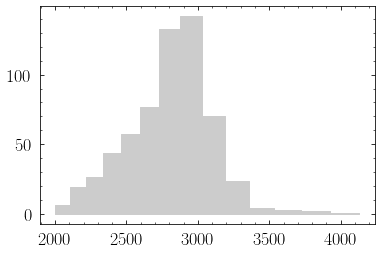

In [5]:
sighist=np.array([  7,  22,  31,  54,  75, 106, 192, 217, 113,  40,   8,   5,   4, 1,   0])
mjjmin=2001
mjjmax=4350
mybinboundaries = np.round(np.logspace(np.log10(mjjmin), np.log10(mjjmax), num=16))
mybincenters = np.array([0.5*(mybinboundaries[i+1] + mybinboundaries[i]) for i in range(0,len(mybinboundaries)-1)])
mybinwidths = np.array([mybinboundaries[i+1] - mybinboundaries[i] for i in range(0,len(mybinboundaries)-1)])

plt.fill_between(mybinboundaries[:-1],sighist*100/mybinwidths,step='post',color='0.8')

### Figure 8, left

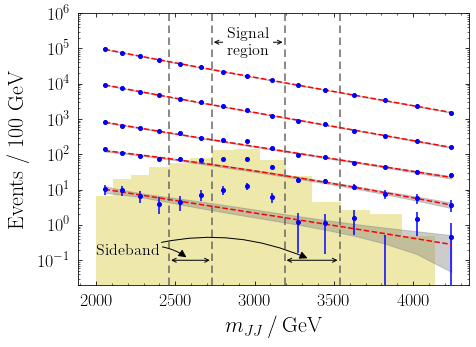

In [6]:
plt.figure(figsize=(5*1.4,5))

for line_i in [4,6,9,11]:
    plt.axvline(binvals[line_i],color='0.4',dashes=[5,3])
plt.fill_between(mybinboundaries[:-1],sighist*100/mybinwidths,step='post',
                 color='palegoldenrod',alpha=1.)
signallabel_y=0.15*10**6
plt.annotate("",xy=(binvals[6],signallabel_y), xytext = (binvals[9],signallabel_y),
            arrowprops=dict(arrowstyle='<->'))

plt.text(0.5*(binvals[6] + binvals[9]),signallabel_y,r"Signal"'\n'r"region",va='center',ha='center',fontsize=smfontsize,
        bbox=dict(facecolor='white',edgecolor='none', alpha=1.0))

sidebandlabel_y=1.0*10**-1

plt.annotate("",xy=(binvals[4],sidebandlabel_y), xytext = (binvals[6],sidebandlabel_y),
            arrowprops=dict(arrowstyle='<->'))
plt.annotate("",xy=(binvals[9],sidebandlabel_y), xytext = (binvals[11],sidebandlabel_y),
            arrowprops=dict(arrowstyle='<->'))
plt.annotate(r"Sideband", xytext=(2000,sidebandlabel_y*4/3), xy = (0.5*(binvals[9] + binvals[11]),sidebandlabel_y),
             fontsize = smfontsize,
             color='white',
             arrowprops=dict(arrowstyle="-|>", #linestyle="dashed",
                color="0.0",
                #patchB=el,
                shrinkB=5,
                connectionstyle="arc3,rad=-0.2",
                ),)

plt.annotate(r"Sideband", xytext=(2000,sidebandlabel_y*4/3), xy = (0.5*(binvals[4] + binvals[6]),sidebandlabel_y),
             fontsize = smfontsize,
             arrowprops=dict(arrowstyle="-|>", #linestyle="dashed",
                color="0.0",
                #patchB=el,
                shrinkB=5,
                connectionstyle="arc3,rad=-0.3",
                ),)
chosen_set = [0,1,4,6,9]

plt.ylabel(r'Events / 100 GeV',fontsize=fontsize)
plt.xlabel(r'$m_{JJ} \, / \, \mathrm{GeV}$',fontsize=fontsize)
plt.ylim([2*10**-2,10**6])

for i in chosen_set:
    add_mjjplot(datasets_sig[4,i,1:],binvals,mask=[6,7,8],verbose=0,plotfile='tmp.png')
    plt.savefig('/mnt/c/Users/Jack/Physics/jj_for_NN/mJJplots_' + str(i) + '.png', bbox_inches='tight')

#plt.xlim([2001,4350])

plt.show()

### Figure 8

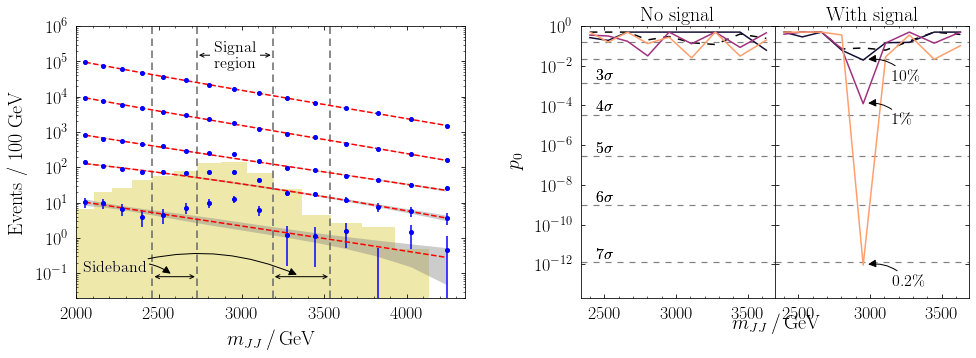

In [10]:
import matplotlib.gridspec as gridspec

fontsize=20
smfontsize=16

binvals = [#1900.,
            2001.,2107.,2219.,2337.,2461.,2592.,2730.,2875.,3028.,3189.,3358.,3536.,3724.,3922.,4131.,4350.]
bincenters = [0.5*(binvals[i] + binvals[i+1]) for i in range(len(binvals)-1)]
bincenters = bincenters[3:12]
masks = [[bin_i-1,bin_i, bin_i+1] for bin_i in range(3,12)]
plt.close('all')

fig = plt.figure(figsize=(16,5))
outer = gridspec.GridSpec(1,2,wspace=0.3,width_ratios=[5,5])

plt_i = 0

inner = gridspec.GridSpecFromSubplotSpec(1, 1,
                    subplot_spec=outer[0])
ax = plt.Subplot(fig, inner[0])
ax.fill_between(mybinboundaries[:-1],sighist*100/mybinwidths,step='post',
                 color='palegoldenrod',alpha=1.)
for line_i in [4,6,9,11]:
    ax.axvline(binvals[line_i],color='0.4',dashes=[5,3])
    
    
signallabel_y=0.15*10**6
ax.annotate("",xy=(binvals[6],signallabel_y), xytext = (binvals[9],signallabel_y),
            arrowprops=dict(arrowstyle='<->'))

ax.text(0.5*(binvals[6] + binvals[9]),signallabel_y,r"Signal"'\n'r"region",va='center',ha='center',fontsize=smfontsize,
        bbox=dict(facecolor='white',edgecolor='none', alpha=1.0))

sidebandlabel_y=0.8*10**-1

ax.annotate("",xy=(binvals[4],sidebandlabel_y), xytext = (binvals[6],sidebandlabel_y),
            arrowprops=dict(arrowstyle='<->'))
ax.annotate("",xy=(binvals[9],sidebandlabel_y), xytext = (binvals[11],sidebandlabel_y),
            arrowprops=dict(arrowstyle='<->'))
ax.annotate(r"Sideband", xytext=(2040,sidebandlabel_y*4/3), xy = (0.5*(binvals[9] + binvals[11]),sidebandlabel_y),
             fontsize = smfontsize,
             color='white',
             arrowprops=dict(arrowstyle="-|>", #linestyle="dashed",
                color="0.0",
                #patchB=el,
                shrinkB=5,
                connectionstyle="arc3,rad=-0.2",
                ),)

ax.annotate(r"Sideband", xytext=(2040,sidebandlabel_y*4/3), xy = (0.5*(binvals[4] + binvals[6]),sidebandlabel_y),
             fontsize = smfontsize,
             arrowprops=dict(arrowstyle="-|>", #linestyle="dashed",
                color="0.0",
                #patchB=el,
                shrinkB=5,
                connectionstyle="arc3,rad=-0.3",
                ),)
chosen_set = [0,1,4,6,9]

[get_p_value(datasets_sig[4,i,1:],binvals,mask=[6,7,8],verbose=0,plotfile='ax',myax=ax)
                   for i in chosen_set]
ax.set_ylabel(r'Events / 100 GeV',fontsize=fontsize)
ax.set_xlabel(r'$m_{JJ} \, / \, \mathrm{GeV}$',fontsize=fontsize)
ax.set_ylim([2*10**-2,10**6])
ax.set_xlim([2001,4350])
fig.add_subplot(ax)

inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1], wspace=0)
axarr = [plt.Subplot(fig, inner[0]),plt.Subplot(fig, inner[1])]


dashes = [5,5]
color='0.5'
linewidth=1.2



linestyles = [{'dashes':[5,5]},{'linestyle':'-'},{'linestyle':'-'},{'linestyle':'-'},{'linestyle':'-'}]
choices = [0,1,4,6]
colors = ['black']
colors.extend([plt.cm.magma(i) for i in np.linspace(0.1,0.8,len(choices)-1)])
# colors = ['black']
# colors.extend([plt.cm.viridis(i) for i in np.linspace(0.1,0.95,len(choices)-1)])
effs = [r"100\%",r"10\%",r"1\%",r"0.2\%"]

for ax in axarr:
    ax.set_yscale('log')
    ax.set_ylim([2.*10**-14,1])
    for sigma in range(1,8):
        ax.axhline(1-norm.cdf(sigma),dashes=dashes,color=color,linewidth=linewidth)
        if sigma > 2:
            sigmastring = r'$' + str(sigma) + '\sigma$'
            axarr[0].text(2500,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=smfontsize)




for eff_i, effchoice in enumerate(choices):

    pvalues_nosig = [get_p_value(ydata[1:],binvals,mask=masks[i],verbose=0,plotfile=None)
                     for i, ydata in enumerate(datasets_nosig[:,effchoice])]

    pvalues_sig = [get_p_value(ydata[1:],binvals,mask=masks[i],verbose=0,plotfile=None)
                   for i, ydata in enumerate(datasets_sig[:,effchoice])]


    axarr[0].plot(bincenters,pvalues_nosig,
                  color=colors[eff_i],
                  **linestyles[eff_i])

    axarr[1].plot(bincenters,pvalues_sig,
                  color=colors[eff_i],
                  **linestyles[eff_i])
    if eff_i > 0:
        axarr[1].annotate(effs[eff_i],fontsize=smfontsize,
                xy=(bincenters[4],pvalues_sig[4]), xycoords='data',
                xytext=(bincenters[4]+200, pvalues_sig[4]/10), textcoords='data',
                arrowprops=dict(arrowstyle="-|>", #linestyle="dashed",
                                color="0.0",
                                #patchB=el,
                                shrinkB=5,
                                connectionstyle="arc3,rad=0.3",
                                ),
                )
    

# axarr[1].annotate("Test",
#             xy=(3000, 10**-7), xycoords='data',
#             xytext=(3200, 10**-8), textcoords='data',
#             arrowprops=dict(arrowstyle="->", #linestyle="dashed",
#                             color="0.0",
#                             #patchB=el,
#                             shrinkB=5,
#                             connectionstyle="arc3,rad=0.3",
#                             ),
#             )

# f.subplots_adjust(wspace=0)
# plt.setp([a.get_yticklabels() for a in f.axes[1:]], visible=False)



# plt.semilogy()

#f.text(0.5,-0.01,r'$m_{JJ} \, / \, \mathrm{GeV}$',ha='center',fontsize=fontsize)
#axarr.text(0.5,-0.01,r'$m_{JJ} \, / \, \mathrm{GeV}$',ha='center',fontsize=fontsize)

axarr[0].set_ylabel(r'$p_0$',fontsize=fontsize)
axarr[0].set_title(r'No signal',fontsize=fontsize)
axarr[1].set_title(r'With signal',fontsize=fontsize)
axarr[0].text(3700,2.75*10**-15,r'$m_{JJ} \, / \, \mathrm{GeV} $',va='top',ha='center',fontsize=fontsize)
axarr[1].set_yticklabels([])
fig.add_subplot(axarr[0])
fig.add_subplot(axarr[1])
#plt.savefig('pvalplots.pdf', bbox_inches='tight')
plt.show()

### Figure 14

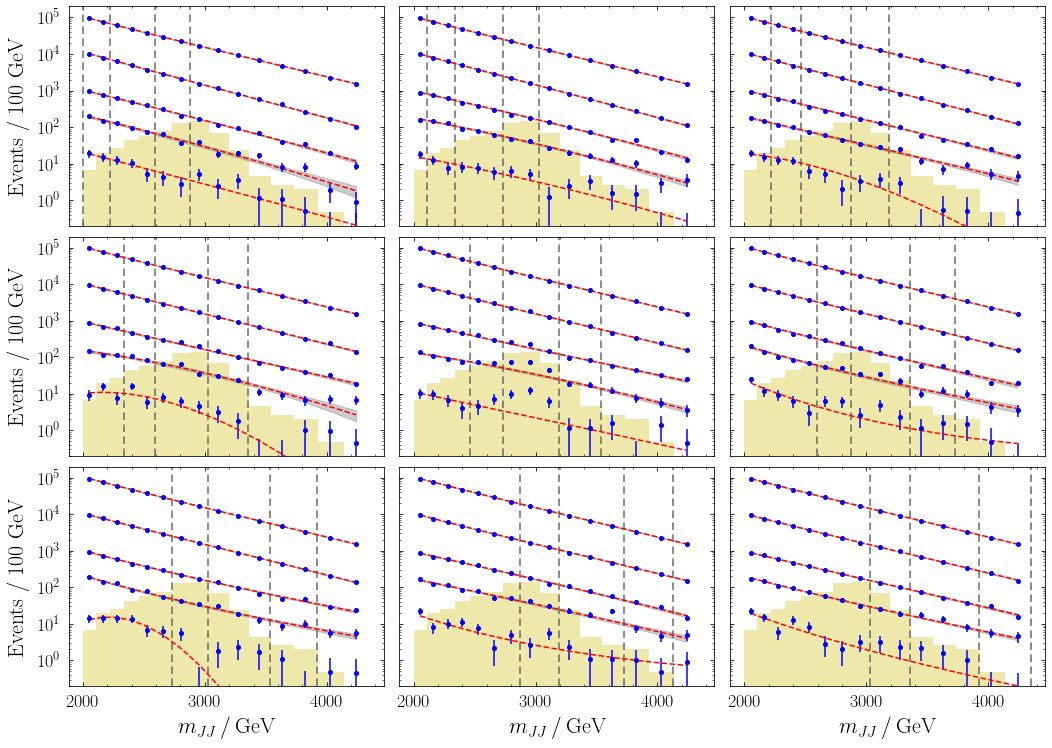

In [9]:
spacing=0.05
f, axarr = plt.subplots(3,3,figsize=(5*1.4*2.5,5*2.5),sharex=True,sharey=True)
for bin_i in range(3,12):
#    plt.close('all')
    
    row = int((bin_i-3)/3)
    col = (bin_i-3)%3
    ax = axarr[row,col]
    ax.fill_between(mybinboundaries[:-1],sighist*100/mybinwidths,step='post',
                 color='palegoldenrod',alpha=1.)
    if row == 2:
        ax.set_xlabel(r'$m_{JJ} \, / \, \mathrm{GeV}$',fontsize=fontsize)
    if col == 0:
        ax.set_ylabel(r'Events / 100 GeV',fontsize=fontsize)
    
    for line_i in [bin_i-3,bin_i-1,bin_i+2,bin_i+4]:
        ax.axvline(binvals[line_i],color='0.4',dashes=[5,3])

    chosen_set = [0,1,4,6,9]
    def plotfit(i):
        if i == 9:
            return False
        else:
            return True
    [add_mjjplot(datasets_sig[bin_i-3,i,1:],binvals,mask=[bin_i-1,bin_i,bin_i+1],verbose=0,plotfile='ax',myax=ax,
                 plotsys = plotfit(i))
                       for i in chosen_set]

    ax.set_ylim([2*10**-1,2*10**5])

f.subplots_adjust(hspace=spacing)
f.subplots_adjust(wspace=spacing)
for axrow in axarr:
    for ax in axrow:
        ax.label_outer()
#plt.savefig('mJJarr_sig.pdf', bbox_inches='tight')
plt.show()

### FIgure 13

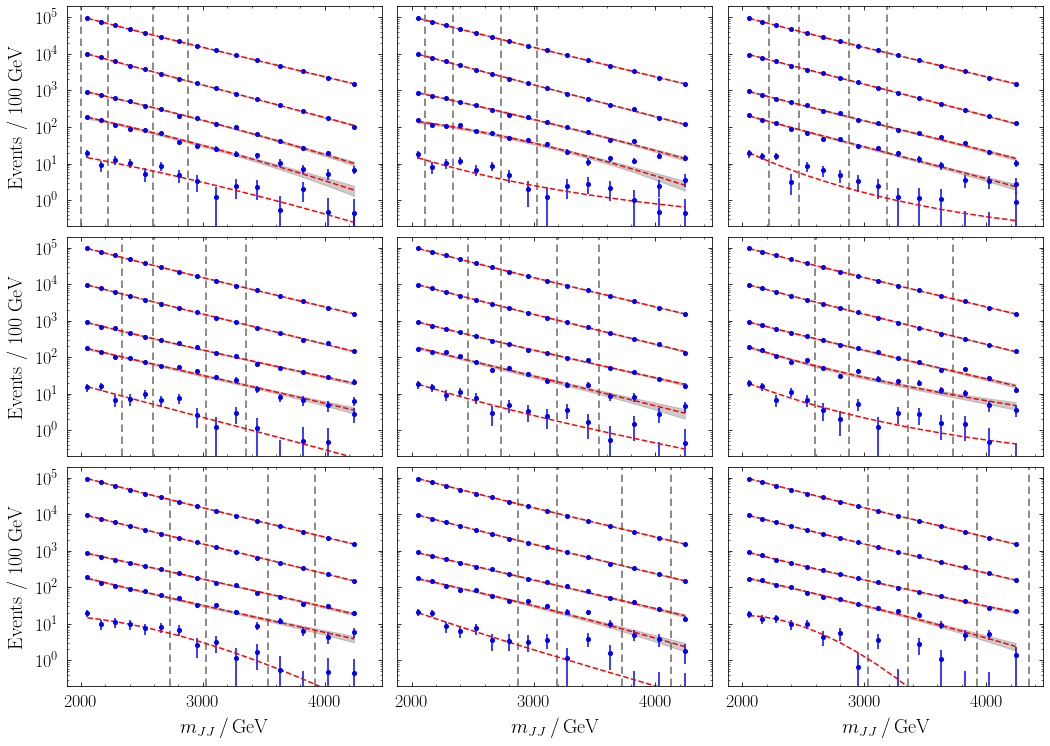

In [12]:
spacing=0.05
f, axarr = plt.subplots(3,3,figsize=(5*1.4*2.5,5*2.5),sharex=True,sharey=True)
for bin_i in range(3,12):
#    plt.close('all')

    row = int((bin_i-3)/3)
    col = (bin_i-3)%3
    ax = axarr[row,col]
    
    if row == 2:
        ax.set_xlabel(r'$m_{JJ} \, / \, \mathrm{GeV}$',fontsize=fontsize)
    if col == 0:
        ax.set_ylabel(r'Events / 100 GeV',fontsize=fontsize)
    
    for line_i in [bin_i-3,bin_i-1,bin_i+2,bin_i+4]:
        ax.axvline(binvals[line_i],color='0.4',dashes=[5,3])

    chosen_set = [0,1,4,6,9]
    def plotfit(i):
        if i == 9:
            return False
        else:
            return True
    [add_mjjplot(datasets_nosig[bin_i-3,i,1:],binvals,mask=[bin_i-1,bin_i,bin_i+1],verbose=0,plotfile='ax',myax=ax,
                 plotsys = plotfit(i))
                       for i in chosen_set]

    ax.set_ylim([2*10**-1,2*10**5])

f.subplots_adjust(hspace=spacing)
f.subplots_adjust(wspace=spacing)
for axrow in axarr:
    for ax in axrow:
        ax.label_outer()
#plt.savefig('mJJarr_nosig.pdf', bbox_inches='tight')
plt.show()